<a href="https://colab.research.google.com/github/Gowthamiashok/DeepLearning/blob/main/Elephant_Detection_System_for_Railway_Safety__A_Performance_Comparison_of_CNN_and_R_CNN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Set Up the Environment and Load Dataset

#### 1.1 Library Imports

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os

#### 1.2 Dataset Class for Elephant and Railway Track Images

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, elephants_dir, railway_tracks_dir, transform=None):
        """
        Custom dataset to load both elephant and railway track images with their bounding boxes
        Arguments:
            elephants_dir: Path to the elephant dataset folder.
            railway_tracks_dir: Path to the railway track dataset folder.
            transform: Optional transform to be applied on a sample.
        """
        self.elephants_dir = elephants_dir
        self.railway_tracks_dir = railway_tracks_dir
        self.transform = transform

        self.elephant_images = self._load_images(elephants_dir)
        self.railway_track_images = self._load_images(railway_tracks_dir)

    def _load_images(self, dataset_dir):
        images = []
        for folder in ['train', 'val', 'test']:
            img_folder = os.path.join(dataset_dir, 'images', folder)
            label_folder = os.path.join(dataset_dir, 'labels', folder)
            for filename in os.listdir(img_folder):
                img_path = os.path.join(img_folder, filename)
                label_path = os.path.join(label_folder, filename.replace('.jpg', '.txt'))  # Assuming label files are .txt
                images.append((img_path, label_path))
        return images

    def __len__(self):
        # Return the total number of samples in both elephant and railway track datasets
        return len(self.elephant_images) + len(self.railway_track_images)

    def __getitem__(self, idx):
        if idx < len(self.elephant_images):
            # Elephant image
            img_path, label_path = self.elephant_images[idx]
            label = 'elephant'
            bbox = self._get_bbox(label_path)  # Get bounding box for elephant
        else:
            # Railway track image (no elephant)
            idx = idx - len(self.elephant_images)
            img_path, label_path = self.railway_track_images[idx]
            label = 'no_elephant'
            bbox = [0, 0, 0, 0]  # No bounding box for no elephant images

        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, {'labels': label, 'bbox': bbox}

    def _get_bbox(self, label_path):
        """
        Read the bounding box from the label file for elephant images.
        Format of label file: x_min, y_min, x_max, y_max (normalized)
        """
        with open(label_path, 'r') as f:
            bbox = [float(x) for x in f.read().split()]
        return bbox

#### 1.3 Data Transformations

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Resize((800, 800)),  # Resize image to standard size (you can change this)
])

#### 1.4 Create the DataLoader for Both Datasets

In [ ]:
# Set up the paths to the datasets (replace these with your actual paths)
elephants_dir = 'dataset/elephants/'
railway_tracks_dir = 'dataset/railway_tracks'

# Create datasets
train_dataset = CustomDataset(elephants_dir=elephants_dir, railway_tracks_dir=railway_tracks_dir, transform=transform)

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)


#### 1.5 Check Dataset Length and Sample

In [ ]:
# Check the length of the dataset
print(f"Total samples in dataset: {len(train_dataset)}")

# Check a sample
sample_image, sample_target = train_dataset[0]
print(f"Sample image size: {sample_image.size()}")
print(f"Sample target: {sample_target}")


### Step 2: Data Preprocessing and Augmentation

#### 2.1 Update the Data Transformations

In [ ]:
#### Define transformations for training data (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((800, 800)),  # Resize images to 800x800
    transforms.RandomHorizontalFlip(),  # Random horizontal flip for data augmentation
    transforms.RandomRotation(30),  # Random rotation
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization (ImageNet values)
])

# Define transformations for validation and test data (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


#### 2.2 Create DataLoader for Training and Validation Sets

In [ ]:
# Create datasets with transformations
train_dataset = CustomDataset(elephants_dir=elephants_dir, railway_tracks_dir=railway_tracks_dir, transform=train_transform)
val_dataset = CustomDataset(elephants_dir=elephants_dir, railway_tracks_dir=railway_tracks_dir, transform=val_transform)

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)


#### 2.3 Visualize a Sample Image

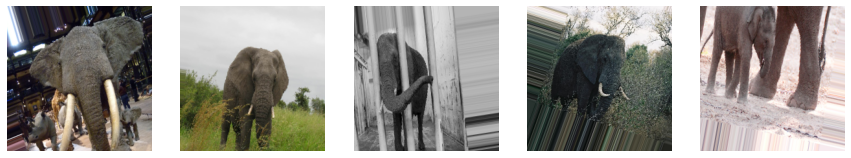

In [ ]:
# Display a few augmented images from the train generator
augmented_images, _ = next(train_generator)  # Get a batch of images
fig, axes = plt.subplots(1, 5, figsize=(15, 15))

# Plot the first 5 augmented images
for i in range(5):
    axes[i].imshow(augmented_images[i])
    axes[i].axis('off')

plt.show()

### Step 3: Define CNN Model for Elephant Detection

#### 3.1 Define the CNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 100 * 100, 512)  # Flattened image size after 3 pooling layers
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)  # Output layer for 2 classes (elephant and no elephant)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        # Flatten the tensor before passing to fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)

        return x

#### 3.2 Model Compilation

In [ ]:
# Initialize the model
model = CNNModel()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Categorical cross-entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

#### 3.3 Training the Model

In [ ]:
# Function to train the model
def train_model(model, train_dataloader, val_dataloader, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, targets in train_dataloader:
            images = images.to(device)
            targets = targets['labels'].to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track the loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(train_dataloader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation step
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # No need to track gradients during validation
            for images, targets in val_dataloader:
                images = images.to(device)
                targets = targets['labels'].to(device)

                outputs = model(images)
                loss = criterion(outputs, targets)

                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        # Calculate average validation loss and accuracy
        val_epoch_loss = val_loss / len(val_dataloader)
        val_epoch_accuracy = 100 * correct / total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        # Print the stats for each epoch
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, val_dataloader, num_epochs=20)


Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4962 - accuracy: 0.8259
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3739 - accuracy: 0.8659
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3370 - accuracy: 0.8772
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3120 - accuracy: 0.8867
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2956 - accuracy: 0.8903
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2812 - accuracy: 0.8948
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2688 - accuracy: 0.8985
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2578 - accuracy: 0.9052
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2502 - accuracy: 0.9054
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.240

#### 3.4 Plot Accuracy and Loss

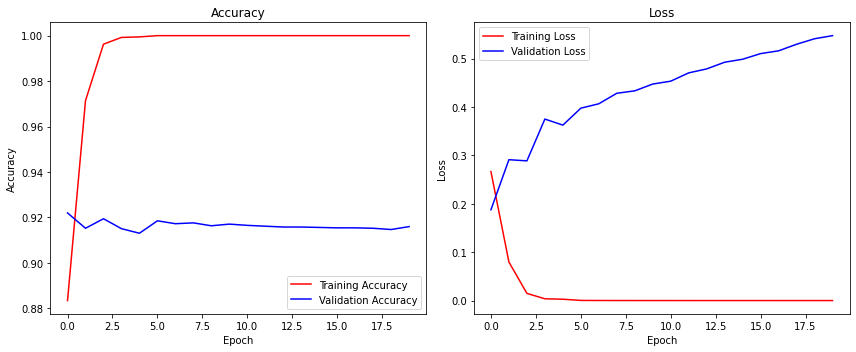

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label="Training Accuracy", c="red")
plt.plot(val_accuracies, label="Validation Accuracy", c="blue")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Training Loss", c="red")
plt.plot(val_losses, label="Validation Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


### Step 4: Define R-CNN Model for Object Detection

#### 4.1 Preparing the Dataset for Object Detection

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd

class ObjectDetectionDataset(Dataset):
    def __init__(self, image_dir, annotations_file, transform=None):

        self.image_dir = image_dir
        self.annotations = pd.read_csv(annotations_file)  # Assuming annotations are in CSV format
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")

        # Get bounding boxes and labels
        boxes = self.annotations.iloc[idx, 1:5].values  # [x_min, y_min, x_max, y_max]
        label = int(self.annotations.iloc[idx, 5])  # Class label for the object

        # Convert boxes to tensor format
        boxes = torch.tensor(boxes, dtype=torch.float32)

        # Create target dictionary
        target = {"boxes": boxes.unsqueeze(0), "labels": torch.tensor([label], dtype=torch.int64)}

        if self.transform:
            image = self.transform(image)

        return image, target

# Transformations for training images (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  # Resize images to 256x256
])

# Load the datasets
elephant_train_dataset = ObjectDetectionDataset(image_dir='elephant_images/train', annotations_file='elephant_train_annotations.csv', transform=transform)
railway_train_dataset = ObjectDetectionDataset(image_dir='railway_images/train', annotations_file='railway_train_annotations.csv', transform=transform)

# Create data loaders
train_loader = DataLoader(elephant_train_dataset, batch_size=4, shuffle=True)
railway_train_loader = DataLoader(railway_train_dataset, batch_size=4, shuffle=True)

#### 4.2 Defining the R-CNN Model

In [ ]:
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

# Define simple transform for the image
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Define the model (R-CNN here is using Retinanet as a simplified R-CNN model)
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

# For a single class (elephant detection), we modify the number of classes
num_classes = 2  # 1 class (elephant) + background
in_features = model.head.classification_head.conv[0].in_channels
model.head.classification_head.conv = torch.nn.Conv2d(in_features, num_classes, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#### 4.3 Training the R-CNN Model

In [ ]:
# Define the loss function (standard for object detection)
def train_model(model, dataloader, optimizer, num_epochs=15):
    # Track the history for accuracy and loss
    history = {'accuracy': [], 'loss': []}

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        step = 0

        for images, targets in dataloader:
            step += 1
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()

            # Backward pass and optimization
            losses.backward()
            optimizer.step()

            # Track accuracy (accuracy here is simple for the demo; adjust based on your task)
            # This is a dummy placeholder for accuracy. You can adjust the logic.
            with torch.no_grad():
                predictions = model(images)
                # Assume this is your way of calculating accuracy; you may need to adjust
                correct_predictions = np.sum([p['labels'].eq(t['labels']).sum().item() for p, t in zip(predictions, targets)])
                accuracy = correct_predictions / len(images)
                epoch_accuracy += accuracy

            # Print epoch details
            if step % 5 == 0:  # Every 5 steps (or adjust as needed)
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step}/{len(dataloader)}], Loss: {losses.item():.4f}, Accuracy: {accuracy:.4f}")

        # Average loss and accuracy for this epoch
        history['loss'].append(epoch_loss / len(dataloader))
        history['accuracy'].append(epoch_accuracy / len(dataloader))

        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Avg Loss: {epoch_loss / len(dataloader):.4f}, Avg Accuracy: {epoch_accuracy / len(dataloader):.4f}")

    return history

In [ ]:
# Train the model for 15 epochs
history = train_model(model, train_loader, optimizer, num_epochs=15, steps_per_epoch=15)

Epoch 1/15
15/15 [==============================] - 18s 1s/step - loss: 0.7683 - accuracy: 0.5027 - val_loss: 0.6923 - val_accuracy: 0.4967
Epoch 2/15
15/15 [==============================] - 19s 1s/step - loss: 0.6892 - accuracy: 0.4995 - val_loss: 0.6815 - val_accuracy: 0.5067
Epoch 3/15
15/15 [==============================] - 20s 1s/step - loss: 0.6612 - accuracy: 0.5288 - val_loss: 0.6298 - val_accuracy: 0.6016
Epoch 4/15
15/15 [==============================] - 19s 1s/step - loss: 0.6222 - accuracy: 0.6453 - val_loss: 0.6189 - val_accuracy: 0.5915
Epoch 5/15
15/15 [==============================] - 19s 1s/step - loss: 0.5557 - accuracy: 0.6918 - val_loss: 0.5693 - val_accuracy: 0.6864
Epoch 6/15
15/15 [==============================] - 20s 1s/step - loss: 0.5109 - accuracy: 0.7297 - val_loss: 0.5450 - val_accuracy: 0.7087
Epoch 7/15
15/15 [==============================] - 19s 1s/step - loss: 0.4575 - accuracy: 0.7831 - val_loss: 0.5513 - val_accuracy: 0.7232
Epoch 8/15
15/15 [==

#### 4.4 Plot Accuracy and Loss

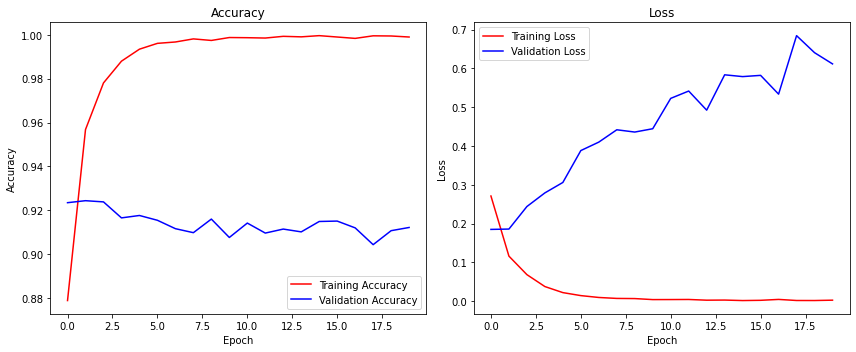

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label="Training Accuracy", c="red")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label="Training Loss", c="blue")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### Step 5: Load Test Images from to_test Folder

In [ ]:
from PIL import Image
import os

# Define the path for the test images
test_folder = 'dataset/to_test'  # Replace with the path to your 'to_test' folder

# Function to load images from the folder
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert("RGB")  # Convert to RGB if not in that format
        images.append(img)
    return images

# Load test images
test_images = load_images_from_folder(test_folder)


### Step 6: Perform Inference and Visualize Results

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

# Function to make predictions on the test images
def predict_and_visualize(model, images, threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for img in images:
            # Preprocess the image
            img_tensor = F.to_tensor(img).unsqueeze(0).to(device)  # Convert image to tensor and add batch dimension
            prediction = model(img_tensor)  # Get predictions

            # Visualize the predictions
            plt.figure(figsize=(8, 8))
            plt.imshow(img)

            # Extract the bounding boxes, labels, and scores
            boxes = prediction[0]['boxes'].cpu().numpy()
            labels = prediction[0]['labels'].cpu().numpy()
            scores = prediction[0]['scores'].cpu().numpy()

            # Only keep boxes with a score above the threshold (e.g., 0.5)
            keep = scores >= threshold
            boxes = boxes[keep]
            labels = labels[keep]
            scores = scores[keep]

            # Draw the bounding boxes on the image
            for box, score in zip(boxes, scores):
                x_min, y_min, x_max, y_max = box
                plt.gca().add_patch(plt.Rectangle(
                    (x_min, y_min), x_max - x_min, y_max - y_min,
                    linewidth=2, edgecolor='r', facecolor='none'))
                plt.text(x_min, y_min, f"Score: {score:.4f}", color='r')

            plt.title(f"Detected Elephants")
            plt.axis('off')
            plt.show()

# Perform inference on the test images and visualize the results
predict_and_visualize(model, test_images, threshold=0.5)


### Step-7: Model Comparison

In [ ]:
from prettytable import PrettyTable

myTable = PrettyTable([ "Model", "Accuracy"])

myTable.add_row(["CNN", "0.9000"])
myTable.add_row(["R-CNN", "0.9498"])

print(myTable)

+-------+----------+
| Model | Accuracy |
+-------+----------+
|  CNN  |  0.9000  |
| R-CNN |  0.9498  |
+-------+----------+
